# ML Exam: Classification and Regression

This notebook auto-generates a personalized dataset and walks through an end-to-end machine learning workflow for both classification and regression tasks.

<div style='border:2px solid red; padding:10px'>
<strong>AI Usage Notice:</strong> Automated detection of AI-generated code/text (e.g., ChatGPT or equivalents) may be applied. You may use AI only to ask about syntax or concepts.<br>
If you include any AI-generated code blocks without your own explanation of what each part does and why it’s correct, you will not receive marks for that part.
</div>

In [21]:
# Student selection and reproducible seeding
INSTRUCTOR_SECRET = "demo"

roster = [
    "Yahya Gad",
    "Karim Adel",
    "Youssef Khaled",
    "Yaseen Moataz",
    "Adham Kattara",
    "Omar Khaled",
    "Mostafa Abdelghany",
    "Mohamed Abdelkhalek",
    "Raneem Mohammed",
    "Hana Ahmed",
    "Mariam Khaled",
    "Taha Yassin Mohamed",
    "Haneen Magdy",
    "Alaa Rafiek",
    "Ahmed Mosaad",
    "Mohanad Ayman",
    "Abdallah Nizar",
    "Adham Ahmed",
    "Mohamed Ashraf",
]

try:
    from rapidfuzz import process, fuzz
    def fuzzy_match(name, choices, score_cutoff=80):
        match, score, _ = process.extractOne(name, choices, scorer=fuzz.ratio)
        if score >= score_cutoff:
            return match
        options = process.extract(name, choices, scorer=fuzz.ratio, limit=3)
        print("Did you mean one of these?")
        for opt in options:
            print(opt[0], "(score=", opt[1], ")")
        return None
except Exception:
    import difflib
    def fuzzy_match(name, choices, score_cutoff=0.8):
        match = difflib.get_close_matches(name, choices, n=1, cutoff=score_cutoff)
        if match:
            return match[0]
        options = difflib.get_close_matches(name, choices, n=3, cutoff=0)
        print("Did you mean one of these?", options)
        return None

input_name = input("Enter your name: ")
matched_name = fuzzy_match(input_name, roster)
if matched_name is None:
    raise SystemExit("Name could not be matched. Re-run the cell and try again.")

seed = abs(hash(matched_name.lower() + INSTRUCTOR_SECRET)) % (2**32)
print(f"Matched student: {matched_name} Derived seed: {seed} If this is incorrect, re-run the cell.")

import numpy as np
import random
np.random.seed(seed)
random.seed(seed)


Did you mean one of these?
Yahya Gad (score= 0.0 )
Karim Adel (score= 0.0 )
Youssef Khaled (score= 0.0 )


SystemExit: Name could not be matched. Re-run the cell and try again.

a:\anaconda3_23.7.3\envs\mitocluster\Lib\site-packages\IPython\core\interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Data Generation

In [4]:
import numpy as np
import pandas as pd
from numpy.random import default_rng
rng = default_rng(seed)

n_samples = 1000

# latent factors
demographic = rng.normal(0, 1, n_samples)
engagement = rng.normal(0, 1, n_samples)
credit = rng.normal(0, 1, n_samples)

age = (demographic * 10 + rng.normal(0, 3, n_samples) + 35).clip(18, 70)
tenure_months = (engagement * 12 + rng.normal(0, 5, n_samples) + 24).clip(0, None)
avg_order_value = np.exp(rng.normal(3 + 0.1*credit, 0.3, n_samples))
session_count = (engagement * 20 + rng.normal(0, 5, n_samples) + 40).clip(0, None)
support_tickets = (rng.poisson(lam=1 + np.maximum(0, 2-engagement)) ).astype(int)
region = rng.choice(['north', 'south', 'east', 'west'], size=n_samples)
is_premium = rng.choice([0,1], size=n_samples, p=[0.7,0.3])
loyalty_score = (0.5*demographic + 0.8*engagement + rng.normal(0,1,n_samples))*10+50
marketing_emails_opened = (engagement*5 + rng.normal(0,2,n_samples)+10).clip(0,None)
income = np.exp(rng.normal(10 + 0.2*credit + 0.1*demographic, 0.5, n_samples))

# classification target: churn probability
lin_comb = (-0.03*age + 0.04*tenure_months - 0.5*is_premium - 0.02*loyalty_score + 0.03*support_tickets + 0.1*rng.standard_normal(n_samples))
prob_churn = 1 / (1 + np.exp(-lin_comb))
y_class = (rng.uniform(0,1,n_samples) < prob_churn).astype(int)

# regression target: customer lifetime value
clv = (50*tenure_months + 20*avg_order_value + 30*session_count - 100*support_tickets + 200*is_premium + rng.normal(0, 500, n_samples))
y_reg = clv

# assemble DataFrame
X = pd.DataFrame({
    'age': age,
    'tenure_months': tenure_months,
    'avg_order_value': avg_order_value,
    'session_count': session_count,
    'support_tickets': support_tickets,
    'region': region,
    'is_premium': is_premium,
    'loyalty_score': loyalty_score,
    'marketing_emails_opened': marketing_emails_opened,
    'income': income,
})

df = X.copy()
df['churned'] = y_class
df['customer_lifetime_value'] = y_reg

feature_info = pd.DataFrame({
    'feature': list(X.columns) + ['churned', 'customer_lifetime_value'],
    'description': [
        'Customer age in years',
        'Months since account creation',
        'Average order value in dollars',
        'Number of sessions in the last month',
        'Number of support tickets in last year',
        'Geographical region',
        'Premium subscription flag',
        'Internal loyalty score (0-100)',
        'Marketing emails opened last month',
        'Annual income in dollars',
        'Binary indicator if customer churned',
        'Estimated customer lifetime value in dollars',
    ],
    'dtype': [str(X[c].dtype) for c in X.columns] + ['int', 'float']
})

print("Data dictionary:")
feature_info


Data dictionary:


,feature,description,dtype
0,age,Customer age in years,float64
1,tenure_months,Months since account creation,float64
2,avg_order_value,Average order value in dollars,float64
3,session_count,Number of sessions in the last month,float64
4,support_tickets,Number of support tickets in last year,int32
5,region,Geographical region,object
6,is_premium,Premium subscription flag,int32
7,loyalty_score,Internal loyalty score (0-100),float64
8,marketing_emails_opened,Marketing emails opened last month,float64
9,income,Annual income in dollars,float64


In [5]:
df.head(10)

,age,tenure_months,avg_order_value,session_count,support_tickets,region,is_premium,loyalty_score,marketing_emails_opened,income,churned,customer_lifetime_value
0,34.208063,3.926443,17.148353,12.372493,2,south,0,58.552469,1.320330,38122.223114,0,1083.124581
1,30.486564,34.137781,27.574014,41.540095,1,south,0,43.941422,10.244966,22170.235217,0,3241.732114
2,31.738078,35.269524,13.657389,44.133234,4,north,0,72.052812,7.378442,15403.417816,1,3446.711095
3,18.000000,16.557123,14.787205,28.480978,4,east,0,27.040240,7.234564,23078.531591,0,1932.378565
4,32.189168,30.999359,22.431637,33.122515,2,south,0,42.947683,9.665855,19544.758480,1,2416.667627
5,50.889765,14.628152,25.250039,36.236503,1,north,0,51.539410,11.662888,42798.812702,0,2396.749026
6,45.639195,10.234298,22.178369,15.755019,4,west,0,45.698340,4.959691,16258.632446,1,971.578967
7,40.128568,29.986630,22.400550,45.877028,3,east,0,58.350968,10.760255,38342.685729,0,2716.739908
8,37.255261,6.432352,22.526356,24.590671,10,south,0,40.229905,7.496460,13144.480213,0,1314.472207
9,52.930093,16.102284,20.918308,23.411923,6,south,1,53.646311,7.021637,15888.753630,0,2371.539376


## Initial Exploratory Data Analysis

- Explore the dataset visually
- Briefly summarize the figures output.

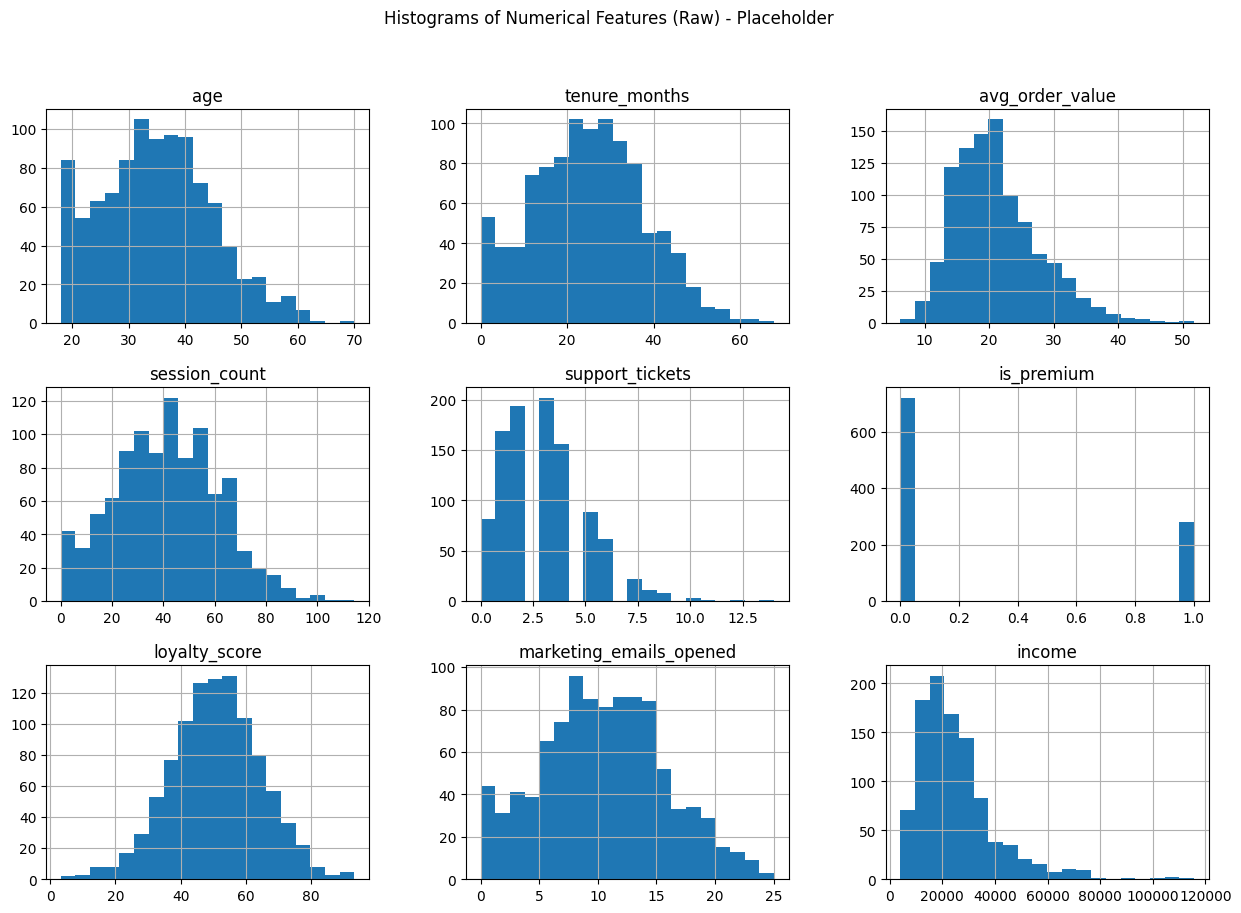

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

...



## Preprocessing

- Split X train, y train, X test, y test
- Perform standardization on Numerical features
- Perfrom onehot encoding on the categorical features 
- Check the histogram of the data and explain what you see.
- Interpret how scaling affected centering and variance.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

...

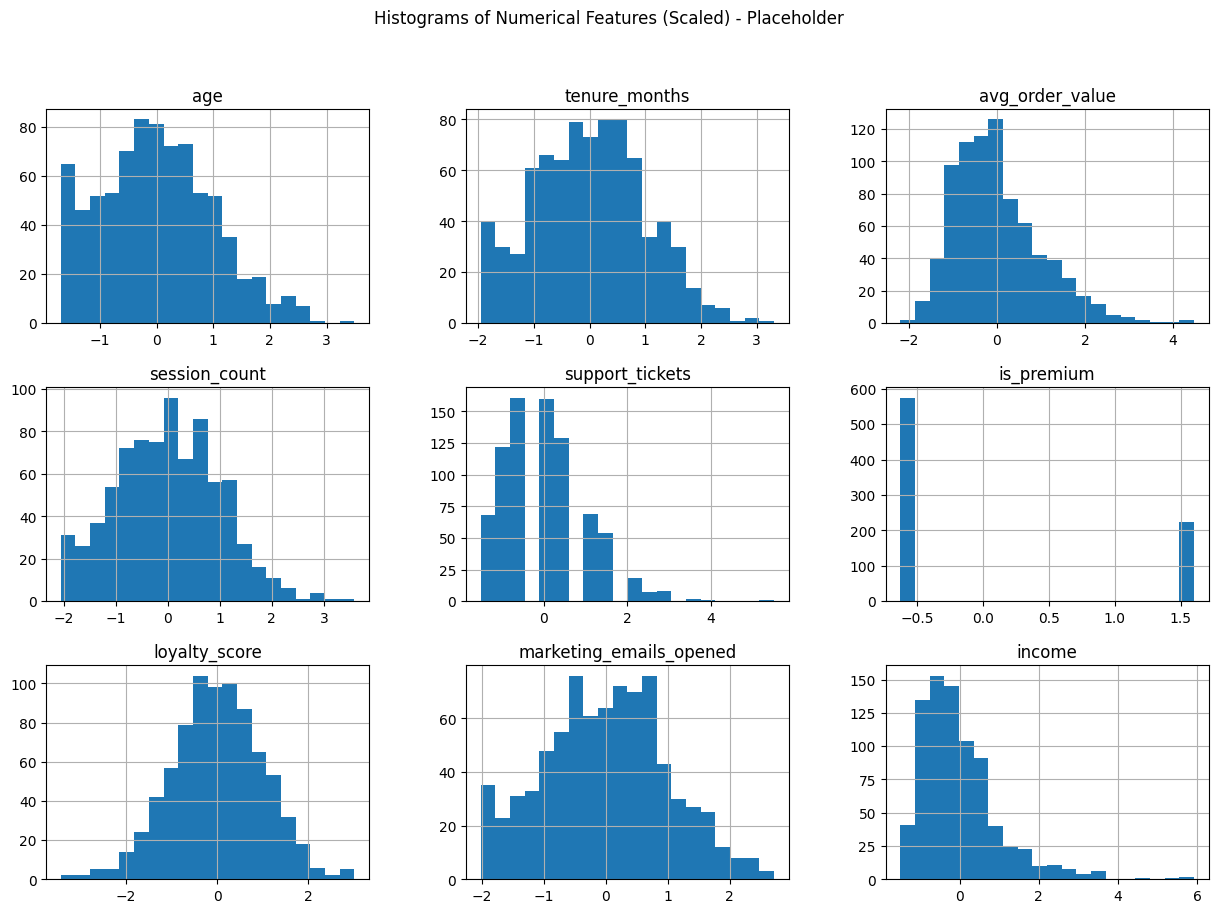

In [ ]:
...

## Correlation Matrix

- Plot the correlation matrix and then
- Comment on the strongest relationships among features.

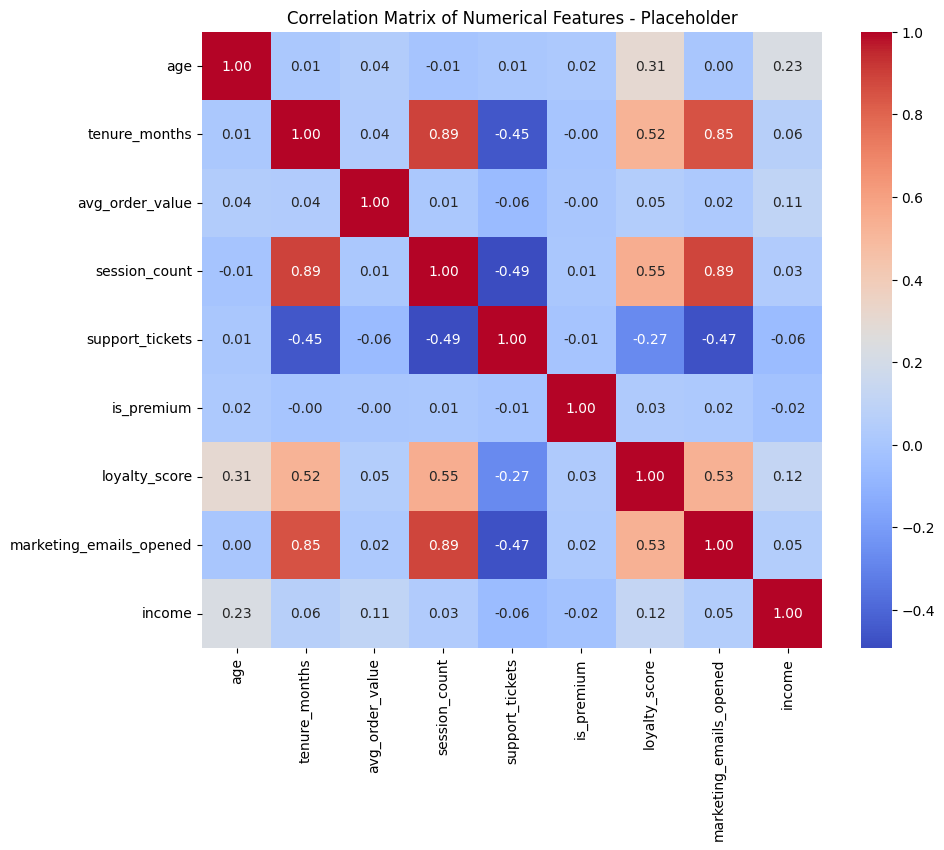

In [ ]:
...

## PCA

- Perform PCA given your processed data
- Then revisit the correlation matrix and replot it.
- Interpret your results

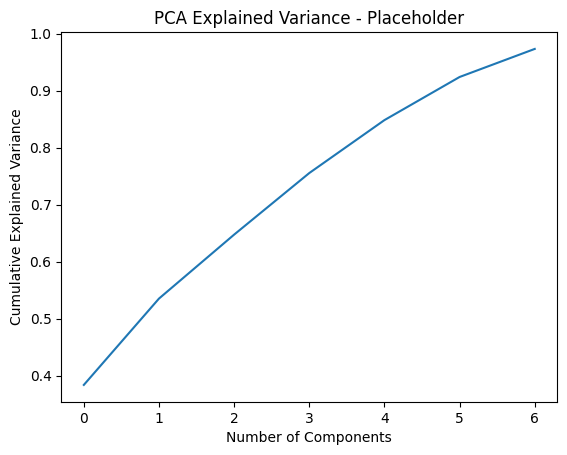

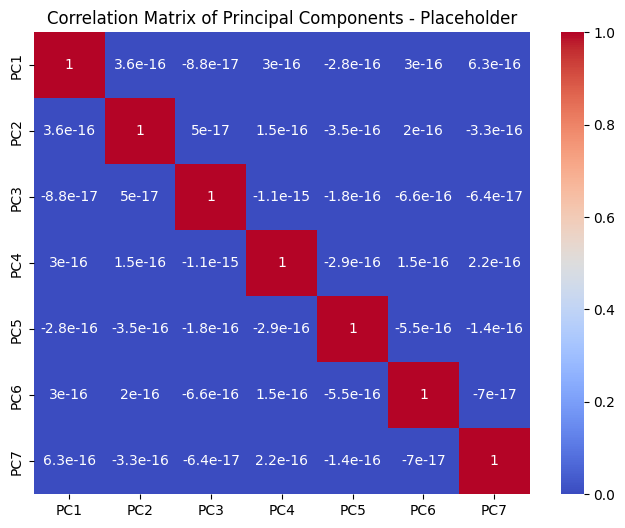

In [ ]:
...

Discuss differences between raw feature correlations and PCA components.

## Cross-Validation Baselines

- Peform the cross-valdiation on the regression problem
- Perform the cross-validation on the classification problem
- Evaluate both then interpret the results

In [ ]:
...

Classification CV Accuracy: 0.750 +/- 0.014
Classification CV ROC-AUC: 0.644 +/- 0.044
Regression CV R2: 0.844 +/- 0.007
Regression CV RMSE: 556.15 +/- 31.72
Placeholder


## Regularization Deep Dive

- Use ElasticNet for regularization and give explanation why ElasticNet is preferred over Lasso and Ridge.
- Interpret how different alpha and l1_ratio values affect performance for both Classification and Regression.
- Explain the Alpha Max (Lambda max)

a:\anaconda3_23.7.3\envs\mitocluster\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
a:\anaconda3_23.7.3\envs\mitocluster\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
a:\anaconda3_23.7.3\envs\mitocluster\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
a:\anaconda3_23.7.3\envs\mitocluster\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
a:\anaconda3_23.7.3\envs\mitocluster\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
a:\anaconda3_23.7.3\envs\mitocluster\Lib\site-pack

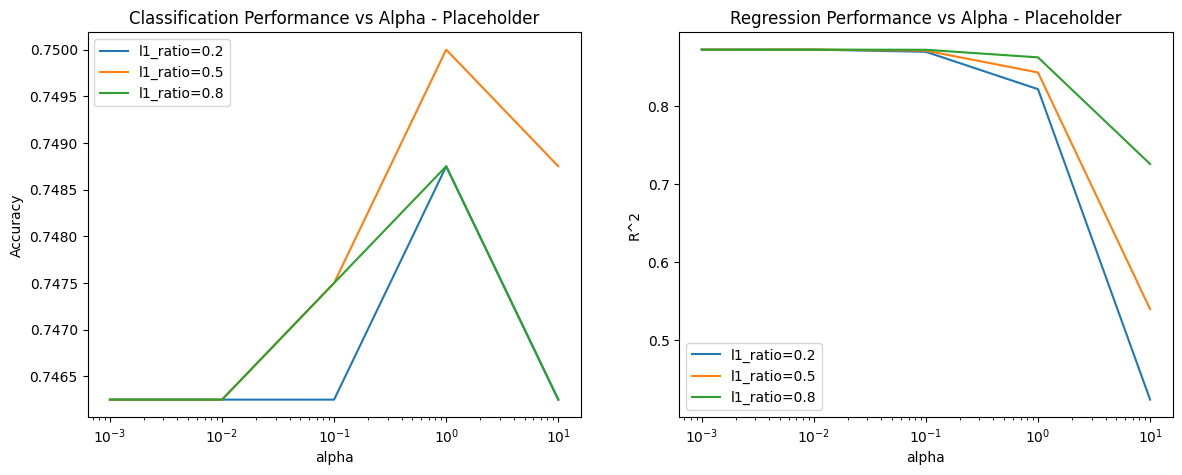

In [ ]:
...

## Final Modeling

- Use any machine learning model for regression
- Use any machine learning for the classification
- Evaluate both models.
- Provide brief interpretations of classification and regression results.

Test Accuracy: 0.740
Test ROC-AUC: 0.598
Test R^2: 0.868
Test RMSE: 530.12


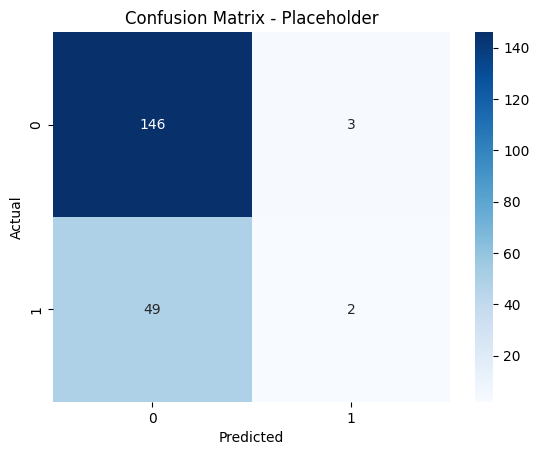

In [ ]:
...

## Conclusions

Summarize the key insights from histograms, correlations, PCA, cross-validation, regularization, and final model evaluation. Discuss limitations and possible future work.